# ANZ synthesised transaction Dataset:

In [369]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import matplotlib.dates as mdates
%matplotlib inline
import pyforest
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


In [316]:
# reading the dataset
df=pd.read_excel("ANZ synthesised transaction dataset.xlsx")

In [317]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


# Exploratory Data Analysis

In [318]:
# summary of the dataset: 12043 rows, 23 columns, no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
status               12043 non-null object
card_present_flag    7717 non-null float64
bpay_biller_code     885 non-null object
account              12043 non-null object
currency             12043 non-null object
long_lat             12043 non-null object
txn_description      12043 non-null object
merchant_id          7717 non-null object
merchant_code        883 non-null float64
first_name           12043 non-null object
balance              12043 non-null float64
date                 12043 non-null datetime64[ns]
gender               12043 non-null object
age                  12043 non-null int64
merchant_suburb      7717 non-null object
merchant_state       7717 non-null object
extraction           12043 non-null object
amount               12043 non-null float64
transaction_id       12043 non-null object
country              12043 non-null object
customer_id          12043 n

In [319]:
df.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000


In [320]:
print('Number of Rows are:{}, Number of columns are:{}'.format(df.shape[0],df.shape[1]))
print('='*100)
print('Datatypes       Count')
print('='*100)
print(df.get_dtype_counts())

Number of Rows are:12043, Number of columns are:23
Datatypes       Count
float64            4
int64              1
datetime64[ns]     1
object            17
dtype: int64


Creating Days and Months out of date so that to acquire on which day of which month the transaction are made the most.

In [321]:
df['Day'] = df['date'].dt.day_name()
df['Day'].head()

0    Wednesday
1    Wednesday
2    Wednesday
3    Wednesday
4    Wednesday
Name: Day, dtype: object

In [322]:
# Creating Month by using the date gives so can be useful for EDA 
df['Month'] = df['date'].dt.month_name()
df['Month'].head()

0    August
1    August
2    August
3    August
4    August
Name: Month, dtype: object

In [323]:
#checking in which Month the Transaction are made most
df['Month'].value_counts()

October      4087
September    4013
August       3943
Name: Month, dtype: int64

# Exploratory Data Analysis

Lets check For the NULL values.

In [324]:

#%%time
def fun_view():
    ''' This Function will return the columns names as index,null_value_count,any unique character we specify & its percentage of occurance per column.'''
    null_values = df.apply(lambda x:x.isnull().sum())
    blank_char = df.apply(lambda x:x.isin(['?']).sum())
    percent_blank_char = df.apply(lambda x:round((x.isin(['?']).sum()/df.shape[0])*100, 2))
    unique_values = df.apply(lambda x:len(x.unique()))
    return pd.DataFrame({'null_values':null_values,
                         '? Values':blank_char,'% ? Values':percent_blank_char
                        ,'unique_values':unique_values})

In [325]:
%%time
print('Function Information',fun_view.__doc__)
view = fun_view()
display(view)

Function Information  This Function will return the columns names as index,null_value_count,any unique character we specify & its percentage of occurance per column.


,null_values,? Values,% ? Values,unique_values
status,0,0,0.0,2
card_present_flag,4326,0,0.0,3
bpay_biller_code,11158,0,0.0,4
account,0,0,0.0,100
currency,0,0,0.0,1
long_lat,0,0,0.0,100
txn_description,0,0,0.0,6
merchant_id,4326,0,0.0,5726
merchant_code,11160,0,0.0,2
first_name,0,0,0.0,80


Wall time: 264 ms


# Observations:

## Null values:
There are lots of null values in our dataset. merchant_code, bpay_biller_code have the highest percentage of null values. so we will either drop or ignore them.Also card_present_flag,merchant_id,merchant_suburb,merchant_state,merchant_long_lat. have same number of missing values let check them if they are in line.if yes then we can delete them.

    

bpay_biller_code,merchant_code as it has above 90% of missing values so we drop them.

# 2. Dropping unnecessary columns:
bpay_biller_code,merchant_code as it has abobe 90% of missing values .so we drop them.

In [326]:
df.drop(['bpay_biller_code','merchant_code'],axis=1,inplace=True)

In [327]:
df.head()

,status,card_present_flag,account,currency,long_lat,txn_description,merchant_id,first_name,balance,date,...,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement,Day,Month
0,authorized,1.0,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,...,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit,Wednesday,August
1,authorized,0.0,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,...,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit,Wednesday,August
2,authorized,1.0,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,...,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit,Wednesday,August
3,authorized,1.0,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,...,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit,Wednesday,August
4,authorized,1.0,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,...,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit,Wednesday,August


# Let's Visualize the NaN values:

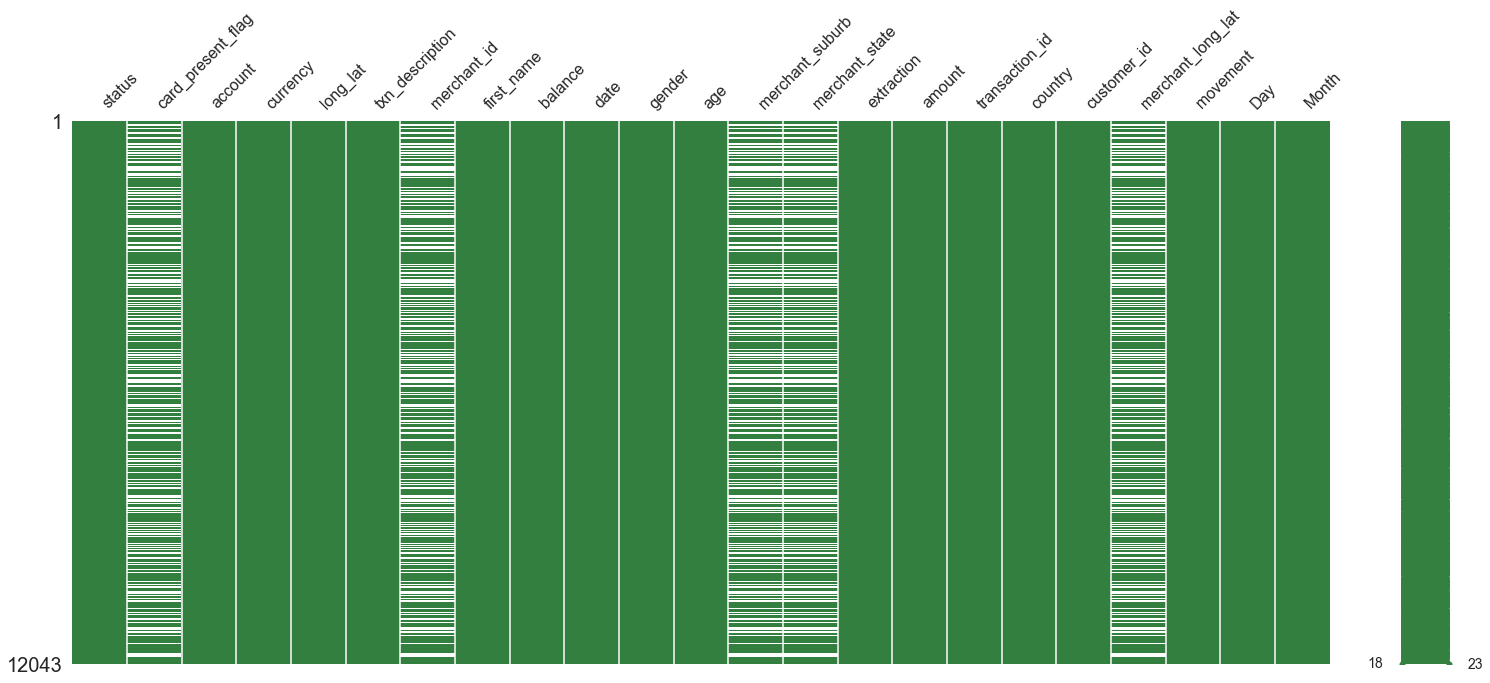

In [344]:
msno.matrix(df,color=(0.20, 0.5, 0.25))

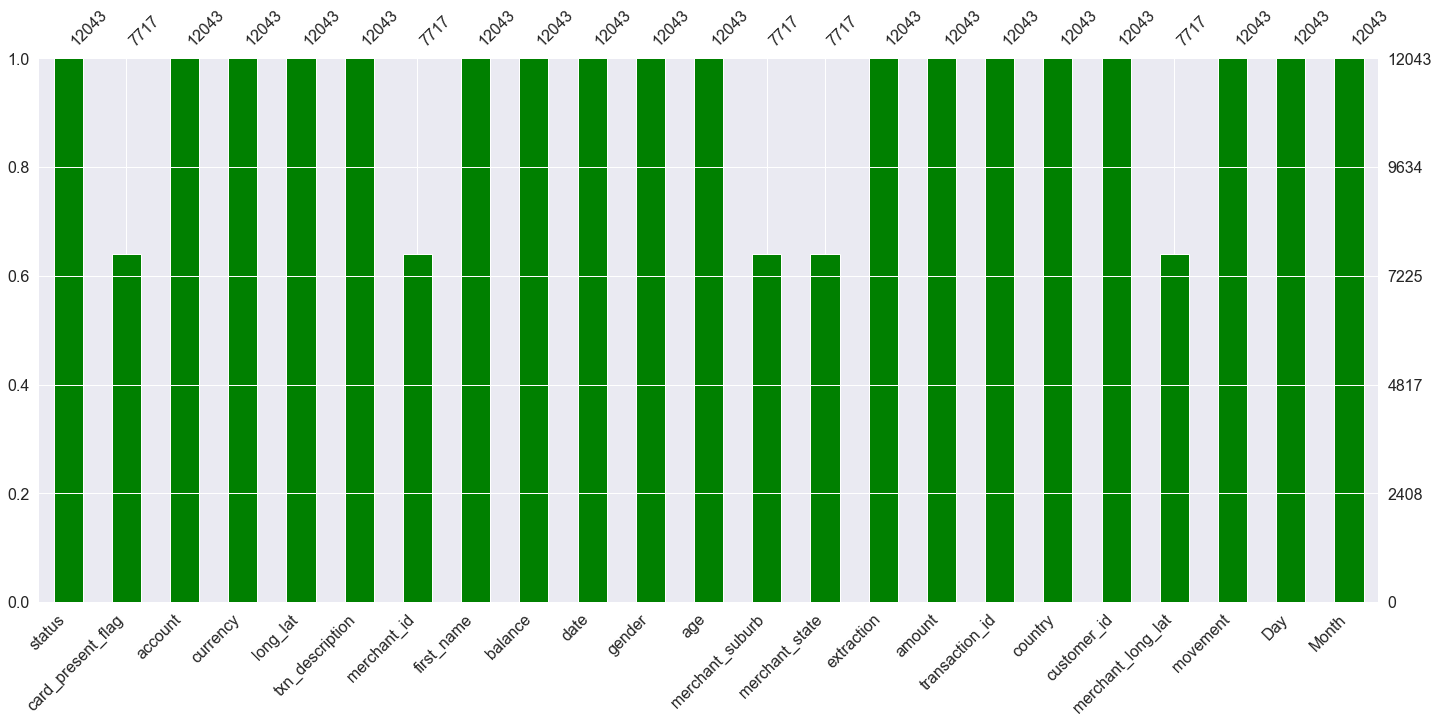

In [345]:
msno.bar(df ,color='green') 

In [346]:
df.isnull().sum()

status                  0
card_present_flag    4326
account                 0
currency                0
long_lat                0
txn_description         0
merchant_id          4326
first_name              0
balance                 0
date                    0
gender                  0
age                     0
merchant_suburb      4326
merchant_state       4326
extraction              0
amount                  0
transaction_id          0
country                 0
customer_id             0
merchant_long_lat    4326
movement                0
Day                     0
Month                   0
dtype: int64

There are 4326 missing value acommon in all 5 card_present_flag,merchant_id,merchant_suburb,merchant_state,merchant_long_lat columns.
lets delete them for now.
we can do some feature engineering and try to classify in some different category but for now lets delete it. As we don't know which state or suburbs these transaction were made.

In [347]:
df1=df.copy()

In [348]:
df.dropna(inplace=True)

In [349]:
df.isnull().sum() #checking for missing value if present.

status               0
card_present_flag    0
account              0
currency             0
long_lat             0
txn_description      0
merchant_id          0
first_name           0
balance              0
date                 0
gender               0
age                  0
merchant_suburb      0
merchant_state       0
extraction           0
amount               0
transaction_id       0
country              0
customer_id          0
merchant_long_lat    0
movement             0
Day                  0
Month                0
dtype: int64

# lets Visualize :

LETS VISUALIZE FIRST WITH ALL MISSING VALUES.

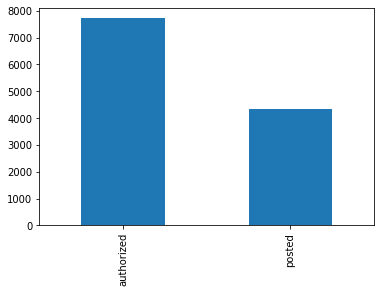

In [143]:
df1.status.value_counts().plot(kind="bar")

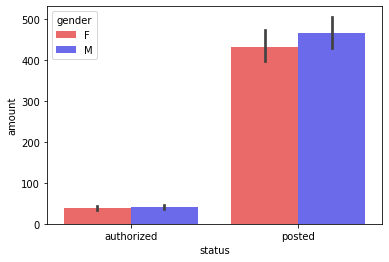

In [145]:
sns.barplot(x='status',y='amount',hue='gender',data=df1,
    palette='seismic_r')

Females and males both have equal number of authorised transactions.
Males have higher number of posted transcation then females.

In [61]:
df2=df1.copy()

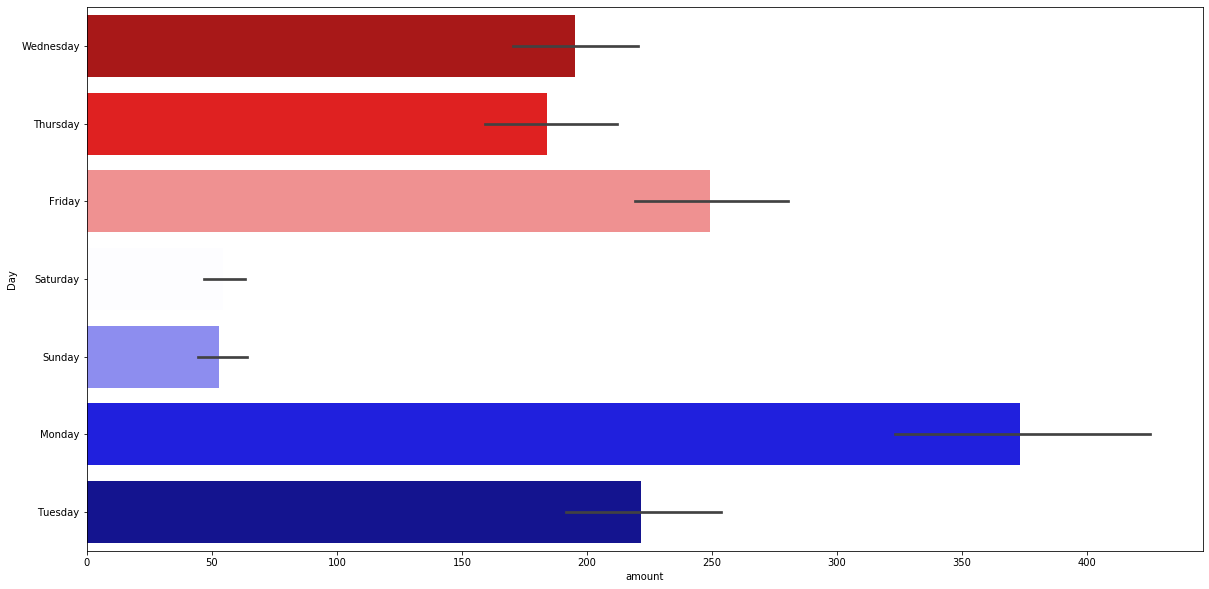

In [272]:
plt.figure(figsize=(20,10))
sns.barplot(x="amount", y="Day", data=df1 ,palette='seismic_r')

# Observations:
The amount of transaction is low on weekends. The highest is on Mondays followed by Friday.which seems people tend to do transaction on starting and ending of the week.

In [229]:
#Average amount of transaction done prday
df1.groupby(['date']).sum()['amount'].mean()

24871.25494505494

In [164]:
#per day average transaction
df1.groupby('Day')['amount'].mean()

Day
Friday       249.353517
Monday       373.221000
Saturday      54.419286
Sunday        53.015845
Thursday     184.010422
Tuesday      221.576456
Wednesday    195.215570
Name: amount, dtype: float64

In [168]:
#per day maximum transaction made.
df1.groupby('Day')['amount'].max()

Day
Friday       8835.98
Monday       8835.98
Saturday     4233.00
Sunday       7081.09
Thursday     8835.98
Tuesday      6024.49
Wednesday    6107.23
Name: amount, dtype: float64

In [227]:
print("Maximum Transaction:",df1.groupby('Month')['amount'].max())
print('='*100)
print("Minimum Transaction:",df1.groupby('Month')['amount'].min())
print('='*100)
print("Average Transaction:",df1.groupby('Month')['amount'].mean())


Maximum Transaction: Month
August       8835.98
October      8835.98
September    8835.98
Name: amount, dtype: float64
Minimum Transaction: Month
August       1.52
October      0.10
September    0.10
Name: amount, dtype: float64
Average Transaction: Month
August       185.121867
October      196.427323
September    182.045903
Name: amount, dtype: float64


# August Month :

The maximum transaction-8835.98

The minimum transaction-1.52

The average transaction-185.121867

# October Month :

The maximum transaction-8835.98

The minimum transaction-0.10

The average transaction-196.427323

# November Month :

The maximum transaction-8835.98

The minimum transaction-0.10

The average transaction-182.045903



In [375]:
df1[['first_name','account','extraction','transaction_id','amount']].sort_values('amount',ascending=False).head(15)

,first_name,account,extraction,transaction_id,amount
10430,Tim,ACC-1523339231,2018-10-19T13:00:00.000+0000,d996300131a641c8bf25f86e1aef9bc6,8835.98
10429,Tim,ACC-1523339231,2018-10-19T13:00:00.000+0000,873a3f11d03d41a99c55a5b1a3850e1a,8835.98
2401,Tim,ACC-1523339231,2018-08-20T13:00:00.000+0000,b608ce5142664a79af4fa071a886c8f7,8835.98
6529,Tim,ACC-1523339231,2018-09-20T13:00:00.000+0000,854ded55d0034ac8b9e91e16334768ca,8835.98
10711,Michele,ACC-819621312,2018-10-21T14:49:45.000+0000,2a882afd1d1c4eb28c3b5ccba14e240d,7081.09
7322,Ronald,ACC-3100725361,2018-09-26T15:00:00.000+0000,7eb1fdb7aefb40d1a8ada1d27f556542,6107.23
11360,Ronald,ACC-3100725361,2018-10-26T15:00:00.000+0000,56e1a0f55f354624a3c713c37415d216,6107.23
833,Richard,ACC-2673069055,2018-08-07T15:00:00.000+0000,b2fedeaf02a6485ba4cf3be69b56a80b,6024.49
4822,Richard,ACC-2673069055,2018-09-07T15:00:00.000+0000,2a20583ac7ce4bffa46624de2f94d5af,6024.49
9903,Christine,ACC-354106658,2018-10-15T15:00:00.000+0000,e4e7f0dd7c504c45990277dad7a8a86c,5103.51


# Observations:
There are transaction which are done twice at same time and same amount for eg christine.

same number of amount is deducted on multiple occasions on same persons account of which tim is the highest. 
also Tim has his deduction on same time every month.

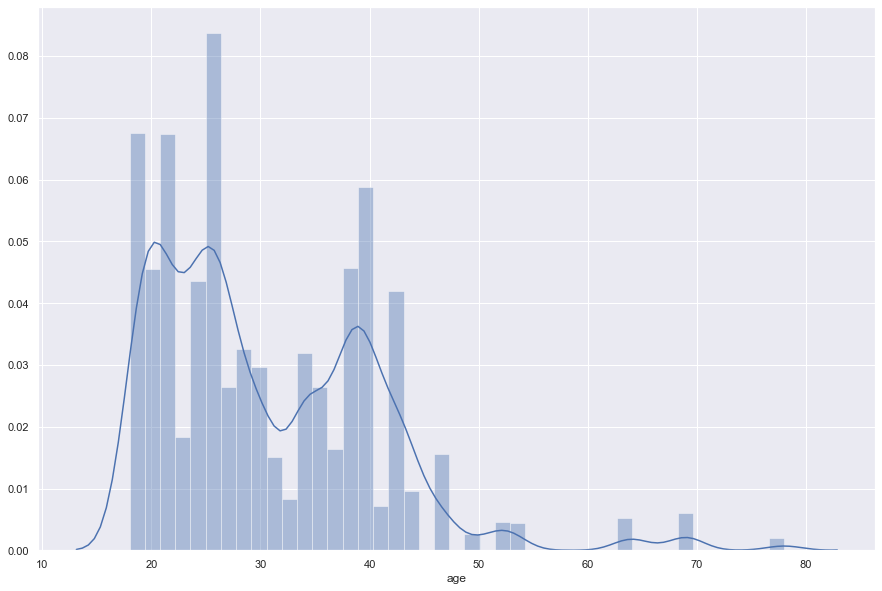

In [376]:
plt.figure(figsize=(15,10))
sns.distplot(df1['age'])
#age distribution with missing values.


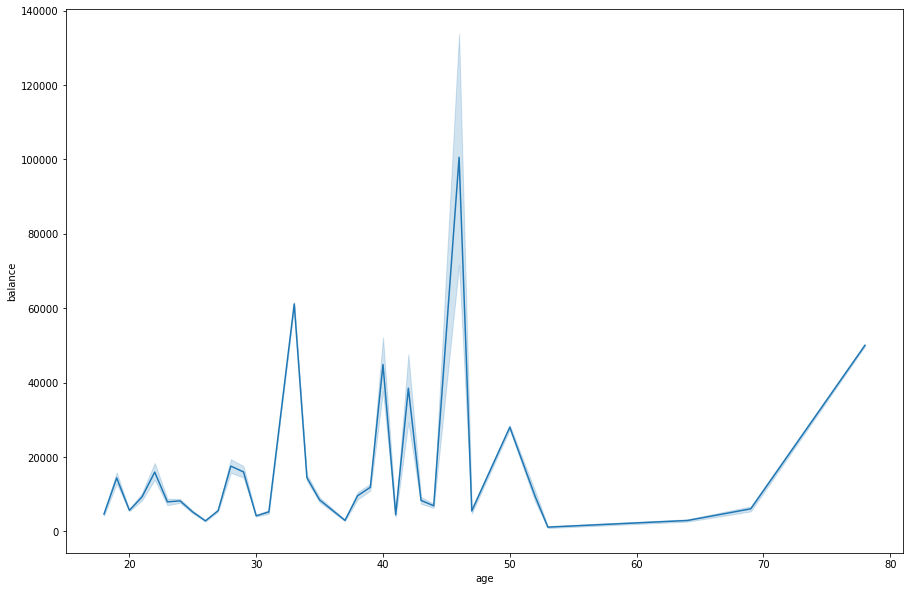

In [282]:
plt.figure(figsize=(15,10))
sns.lineplot(x='age' , y='balance' , data=df)
#people having highest amount of balance lies between 40 and 50s. where else the average age is around 30-35.


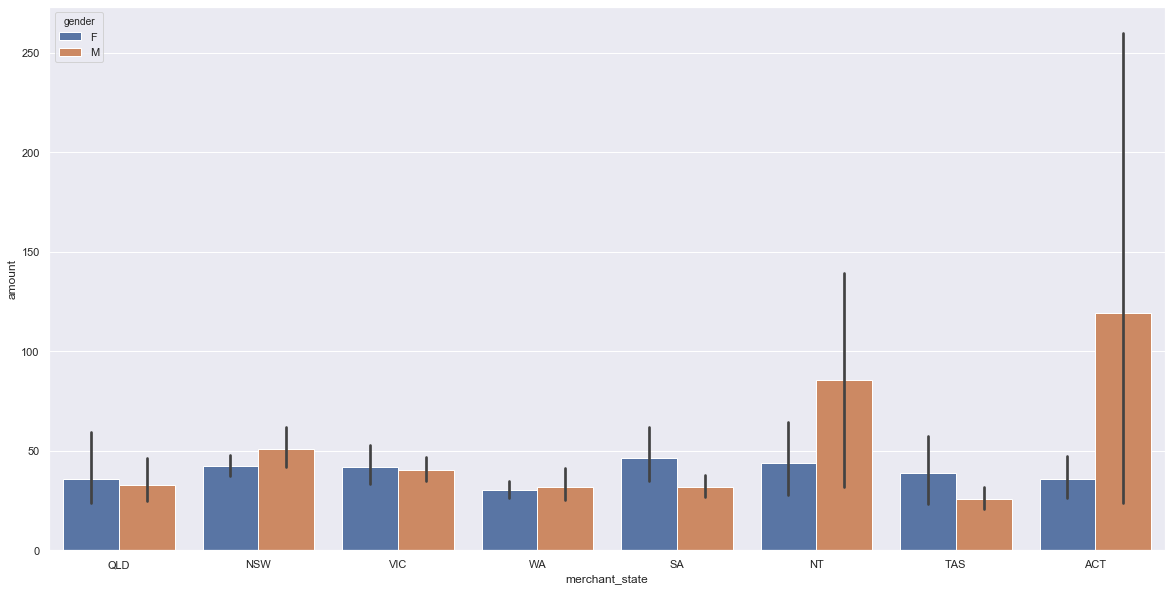

In [377]:
plt.figure(figsize=(20,10))
sns.barplot(y="amount", x="merchant_state", hue="gender",data=df)
#we are using the cleaned dataset here which has no null values.as missing state had some null values.
#based on gender transaction that take place in every state.


In [262]:
df.merchant_state.value_counts()

NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merchant_state, dtype: int64

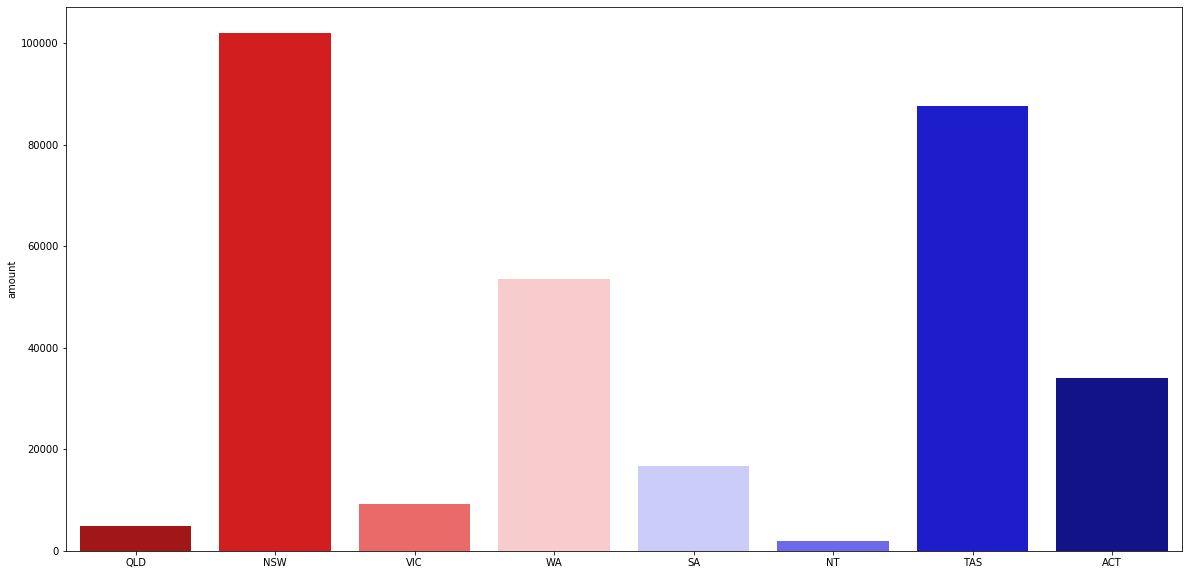

In [275]:
X=df['merchant_state'].unique()
Y=df.groupby(['merchant_state']).sum()['amount']
plt.figure(figsize=(20,10))
sns.barplot(y=Y, x=X,data=df,palette='seismic_r')

In [283]:
frequent_user = df['first_name'].value_counts(sort=True).nlargest(10)
frequent_user

Diana          531
Michael        519
Jeffrey        316
Joseph         306
Jessica        286
Kimberly       260
Tonya          248
Richard        237
Rhonda         220
Christopher    182
Name: first_name, dtype: int64

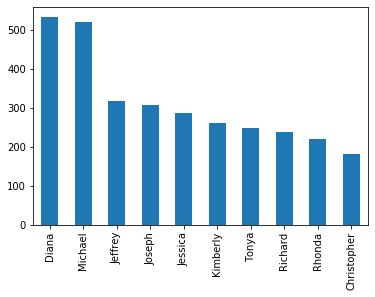

In [292]:
df['first_name'].value_counts(sort=True).nlargest(10).plot(kind="bar")

merchant_state  gender
ACT             F           46
                M           27
NSW             M         1189
                F          980
NT              F          200
                M            5
QLD             F          800
                M          756
SA              F          245
                M          170
TAS             M           52
                F           16
VIC             M         1213
                F          918
WA              F          657
                M          443
Name: gender, dtype: int64


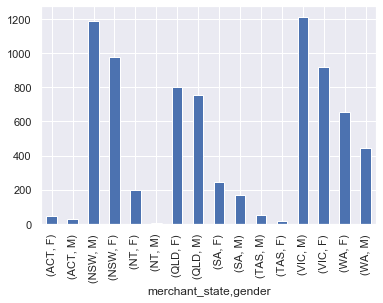

In [357]:
#State wise transaction of male and females.
state= df.groupby(['merchant_state'])
print(state['gender'].value_counts(normalize=True))
state['gender'].value_counts().plot(kind=bar)

In [358]:
pd.crosstab([df1.merchant_state,df1.gender],columns='count')

col_0                  count
merchant_state gender       
ACT            F          46
               M          27
NSW            F         980
               M        1189
NT             F         200
               M           5
QLD            F         800
               M         756
SA             F         245
               M         170
TAS            F          16
               M          52
VIC            F         918
               M        1213
WA             F         657
               M         443

In [360]:
#minimun and Maximum Transaction State wise
statewise=df.groupby('merchant_state')
sum_state=statewise['amount'].agg(['mean','max','min'])
sum_state

,mean,max,min
merchant_state,,,
ACT,66.803836,1348.47,4.50
NSW,47.036316,4233.00,0.10
NT,44.726293,1285.09,1.71
QLD,34.372397,7081.09,0.10
SA,40.425470,909.61,3.28
TAS,28.866618,133.31,7.35
VIC,41.099953,3680.71,0.10
WA,30.901873,1692.56,2.05


# Lets Map The Cordinates:

In [365]:
df['long_lat'].head()

0    153.41 -27.95
1    153.41 -27.95
2    151.23 -33.94
3    153.10 -27.66
4    153.41 -27.95
Name: long_lat, dtype: object

In [366]:
# new data frame with split value columns 
co_ords = df["long_lat"].str.split(" ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
df["longitude"]= co_ords[0] 
  
# making separate last name column from new data frame 
df["latitude"]= co_ords[1] 

In [367]:
df['latitude']=pd.to_numeric(df['latitude'])
df['longitude']=pd.to_numeric(df['longitude'])

In [373]:
map = folium.Map(location=['-25.2744','133.7751'],tiles='CartoDBpositron',zoom_start=7)


k= MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        k.add_child(Marker([row['latitude'], row['longitude']]))
map.add_child(k)

Majority of transaction are seen in Perth ,Melbourne, Sydney, Adelaide and Brisbane.

# Observations:

There were lot of null values in our dataset. merchant_code, bpay_biller_code have the highest percentage of null values. so we dropped or ignored them.
Also card_present_flag,merchant_id,merchant_suburb,merchant_state,merchant_long_lat had same number of missing values.we conisdered both during visualization.
As Most of the customer pay /transact a particular amount every month we can either use that information further in feature enginnering.

1.Authorization / Posted status:
    Females and males both have equal number of authorised transactions. Males have higher number of posted transcation then females.
    
 2.Duplicate values are also present.

2.The amount of transaction is low on weekends. The highest is on Mondays followed by Friday.which seems people tend to do transaction on starting and ending of the week.

3.August Month :
The maximum transaction-8835.98

The minimum transaction-1.52

The average transaction-185.121867

October Month :
The maximum transaction-8835.98

The minimum transaction-0.10

The average transaction-196.427323

November Month :
The maximum transaction-8835.98

The minimum transaction-0.10

The average transaction-182.045903


The average transaction per day in general: 24871.25494505494

Maximum transaction amount of each day:
Friday       8835.98
Monday       8835.98
Saturday     4233.00
Sunday       7081.09
Thursday     8835.98
Tuesday      6024.49
Wednesday    6107.23

Avgerage transaction amount on each day:
Friday       249.353517
Monday       373.221000
Saturday      54.419286
Sunday        53.015845
Thursday     184.010422
Tuesday      221.576456
Wednesday    195.215570

4.people having highest amount of balance lies between 40 and 50s. 
where else the average age is around 30-35(Data with Missing values).

5.States like  New South Wales(NSW) and Tasmania(TAS)  have higher transaction while  Victoria(VIC),
Queensland(QLD) and Northern Territory(NT) have the lowest rate.

6.These are the Frequent users:
Diana          531
Michael        519
Jeffrey        316
Joseph         306
Jessica        286
Kimberly       260
Tonya          248
Richard        237
Rhonda         220
Christopher    182

7.New South Wales(NSW) and Victoria(VIC have higher number of Male transaction while Queensland(QLD) and WA has highest number of females transactors as compared,
8.Majority of transaction are seen in Perth ,Melbourne, Sydney, Adelaide and Brisbane.
